<a href="https://www.kaggle.com/code/samithsachidanandan/decision-tree-from-scratch-in-python?scriptVersionId=270205962" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Decision Tree

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

Some advantages of decision trees are:

* Simple to understand and to interpret. Trees can be visualized.

* Requires little data preparation. Other techniques often require data normalization, dummy variables need to be created and blank values to be removed. Some tree and algorithm combinations support missing values.

* The cost of using the tree (i.e., predicting data) is logarithmic in the number of data points used to train the tree.

* Able to handle both numerical and categorical data. However, the scikit-learn implementation does not support categorical variables for now. Other techniques are usually specialized in analyzing datasets that have only one type of variable. See algorithms for more information.

* Able to handle multi-output problems.

* Uses a white box model. If a given situation is observable in a model, the explanation for the condition is easily explained by boolean logic. By contrast, in a black box model (e.g., in an artificial neural network), results may be more difficult to interpret.

* Possible to validate a model using statistical tests. That makes it possible to account for the reliability of the model.

* Performs well even if its assumptions are somewhat violated by the true model from which the data were generated.

The disadvantages of decision trees include:

* Decision-tree learners can create over-complex trees that do not generalize the data well. This is called overfitting. Mechanisms such as pruning, setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.

* Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.

* Predictions of decision trees are neither smooth nor continuous, but piecewise constant approximations as seen in the above figure. Therefore, they are not good at extrapolation.

* The problem of learning an optimal decision tree is known to be NP-complete under several aspects of optimality and even for simple concepts. Consequently, practical decision-tree learning algorithms are based on heuristic algorithms such as the greedy algorithm where locally optimal decisions are made at each node. Such algorithms cannot guarantee to return the globally optimal decision tree. This can be mitigated by training multiple trees in an ensemble learner, where the features and samples are randomly sampled with replacement.

* There are concepts that are hard to learn because decision trees do not express them easily, such as XOR, parity or multiplexer problems.

* Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree.

**Key Parts of a Decision Tree**

* Root Node :  Its the staring point that containes the whole dataset
* Branches : Its the outcome of decision on each feature
* Internal / Decision Nodes : Its the point where the data is split based on the feature values
* Leaf Nodes : its the terminal node that gives the prediction/  


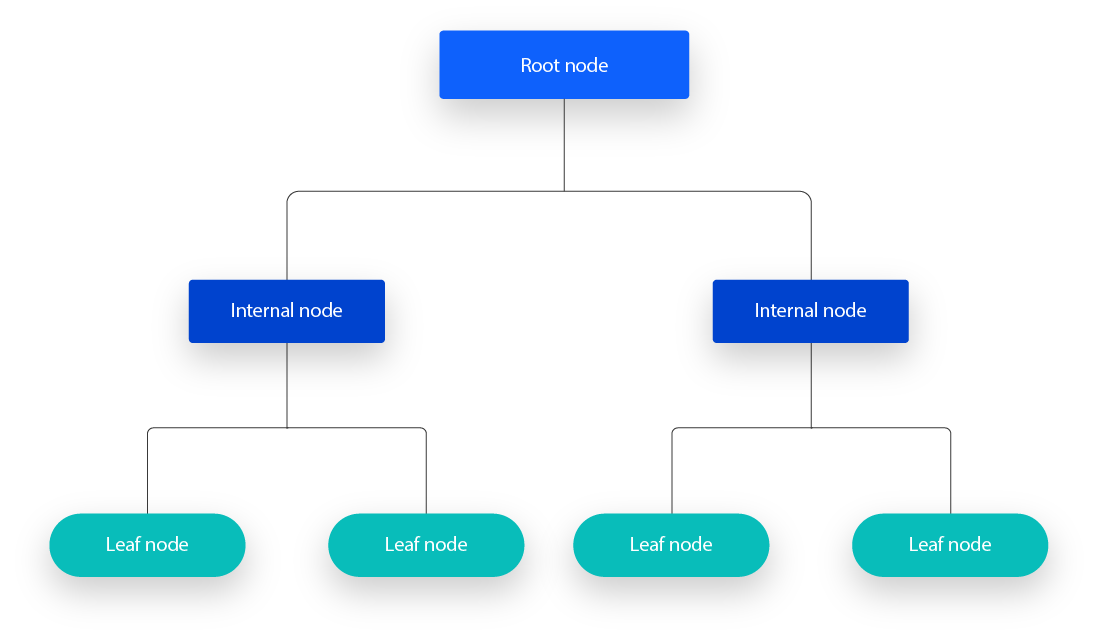

For More Details: (https://scikit-learn.org/stable/modules/tree.html)[https://scikit-learn.org/stable/modules/tree.html]

### Importing the necessary libraries

In [1]:
from collections import Counter

import numpy as np

### Entrpy function 

Computes the entropy of labels y using the formula for Shannon entropy. This quantifies label 'disorder' at each node, a key metric for splitting decisions.

In [2]:
def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])


### Creating the class node 

Represents a general tree node. Contains split details (feature, threshold) and children (left, right), or a single class value for leaf nodes.

In [3]:
class Node:
    def __init__(
        self, feature=None, threshold=None, left=None, right=None, *, value=None
    ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

### Main Decision Tree 

First we are initializing the key hyperparameters like minimum samples per split, max tree depth, number of features and then in fit function tiggers the tree building and then in predict function is returning the predict labels for input X using tree traversal. In the grow_tree function we are building the tree by checking the stopping criteria and then finding the best split by by maximizing information gain and then building the left and right children. Then in the best_criteria function it will return the feature and threshold with the best information gain. In the information gain we calculate reduction in entropy for a candidate split. Finaly we need to define function split, traverse and most_common. In that split gives the left and right by threshold, traverse will traverse the tree to classify  a single input. Most_common will return the label which is most common. 

In [4]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (
            depth >= self.max_depth
            or n_labels == 1
            or n_samples < self.min_samples_split
        ):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common



### Testing

In [5]:

if __name__ == "__main__":
    # Imports
    from sklearn import datasets
    from sklearn.model_selection import train_test_split

    def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy

    data = datasets.load_breast_cancer()
    X, y = data.data, data.target

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1234
    )

    clf = DecisionTree(max_depth=10)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy(y_test, y_pred)

    print("Accuracy:", acc)

Accuracy: 0.9385964912280702
